# Workload Effect on Pitcher Injury

<!-- ## Goal: 
Determine if we can find:
1) Maximize the predictability of the probability of a pitcher getting injured

## Background:
For our (1) goal, we want to predict the probability that a pitcher will get injured as a result of workload, rest (or lack thereof), distance traveled, etc. Essentially, given some features regarding what the pitcher has recently done, we can determine the probability that he'll get injured, should he play the next game. In a sense, we're trying to come up with a solution for teams', such that, based on the probability that results from the features we mentioned, a manager or top decision-maker would make judgdment (e.g., our probability induces a certain threshold such that meeting that threshold induces the idea of resting that pitcher instead of letting him pitch and risk an injury). 

Now we understand that there is one glaring issue, and that is that there are many other confounding factors that induce an injury that might not necessarily *be* correlated with workload (e.g., the ball comes back to the pitcher and hits them and takes them out, the pitcher's form wasn't quite right and it caused an inury as a result of straining your body to come up with velo). To account for this, we want to focus on types of injuries that we are confident *are* correlated with workload, and we'll use scientific evidence to support this (e.g., torn UCL). The reason to avoid those other "freak" types of injuries is that they are a potential source of noise/bias as mentioned previously, some injuries are just not a result of workload, meaning it is entirely possible that our models could *learn* from these types of injuries and determine some kind of relationship with the probability of an injury, which we would not want. 

To approach this problem, we want to take a step back and view this problem from another lens. That being: Industrial Engineering. Essentially, we want to view pitchers as "machines," and as a result, we want to estimate the "failure" rate (injury rate) of these "machines" as a function of workload cycles, rest, and travel. Meaning, we want to quantitatively come up with policies for the pitcher that are analogous to process optimizations. As we want to identify when the injury risk of these pitchers accelerate, such that we can prevent this *potential* injury in order to maximize pitcher usage, and minimize any waste, cost, or downtime.

In future iterations, we'd be interested in learning about *true* causal effects in terms of pitcher injuries, and whether or not the factors we talked about (e.g., workload, rest, etc.) have that kind of effect.

## Methodology: -->


To approach this problem, we first want to understand if there *are* any type of relationships between these workload variables and injury probability. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
from pybaseball import statcast
import requests

pd.set_option('display.max_columns', None)

purple_color = '#5F249F'
teal_color = '#005F61'

## Helper Functions

In [2]:
def get_name_birth(id: int):
    """
    A get function to find attributes of each player based on their mlb id using MLB's Stats API

    Note: you have to be online to run this
    """
    url = f"https://statsapi.mlb.com/api/v1/people/{id}"
    r = requests.get(url).json()
    list_attr = [r['people'][0]['birthDate'].split('-')[0], 
                 r['people'][0]['primaryPosition']['abbreviation'], 
                 r['people'][0]['birthCountry'], 
                 r['people'][0]['height'], 
                 r['people'][0]['weight'],
                 ]
    
    list_attr[3] = int(list_attr[3].split(' ')[0].strip("'"))*12 + int(list_attr[3].split(' ')[1].strip("\"")) ## changes 6'2" into inches
    list_attr[4] = float(list_attr[4]) ## makes sure weight is a number
    return list_attr

In [3]:
get_name_birth(673548)

['1994', 'RF', 'Japan', 72, 182.0]

In [5]:
def overlapping_injury_checker(player_df):
    """
    Checks a pitcher's injury logs to determine if they had an arm injury that overlapped from the previous season into the next
    Deals with those arm injuries because they're being considered twice for a single injury that occurred due to being logged in separate years with the new ILs
    Gets rid of the injury log for the one in the new season
    """
    df = player_df.sort_values('start_date').copy()
    rows_to_drop = []

    for i in range(1, len(df)):
        prev_row = df.iloc[i-1]
        curr_row = df.iloc[i]

        ## only looks at arm injuries for both cases
        if prev_row['injury'] != 'Arm' or curr_row['injury'] != 'Arm':
            continue

        ## new-season IL must be before season started
        if curr_row['start_date'] >= curr_row['season_start']:
            continue

        ## last season IL must end on/after the season end 
        if prev_row['end_date'] < prev_row['season_end']:
            continue

        ## the years must be consecutive
        if curr_row['year'] != prev_row['year'] + 1:
            continue

        rows_to_drop.append(curr_row.name)

    return df.drop(rows_to_drop)

# Data Cleaning + Prep

### MLB Statcast Data

In [ ]:
def load_year_data(year: int):
    """
    Creates the relevant pitcher data for each given year
    Should take about 5 min to run for individual year
    """
    df = pyb.statcast(f'{year}-03-01', f'{year}-11-30').copy()
    df = df[df['game_type'] == 'R'].sort_values(by=['game_date', 'game_pk', 'inning', 'at_bat_number'], ascending=True).reset_index(drop=True).copy()
    df['game_date'] = pd.to_datetime(df['game_date'])
    ## adds the pitch group to simplify pitch usage
    fastball_pitches = ['FF', 'FC', 'SI']
    breaking_pitches = ['CU', 'KC', 'SC', 'SL', 'SV', 'ST']
    offspeed_pitches = ['CH', 'FO', 'FS']
    df['pitch_group'] = df['pitch_type'].apply(lambda x: 'FB' if x in fastball_pitches 
                                            else 'BB' if x in breaking_pitches 
                                            else 'OS' if x in offspeed_pitches 
                                            else 'Other')
    df['pitch_type'] = df['pitch_type'].apply(lambda x: 'FF' if x == 'FA' else x) ## changes FA to FF for consistency
    df = df[~df['pitch_type'].isin(['UN', 'PO', 'EP', 'KN', 'CS'])].reset_index(drop=True).copy()
    df = df.rename(columns={'release_speed': 'velo', 
                            'pfx_x': 'hb', 
                            'pfx_z': 'ivb', 
                            'release_spin_rate': 'spin', 
                            'release_extension': 'ext',
                            'release_pos_x': 'hrel',
                            'release_pos_z': 'vrel',
                            }).copy()
    df[['hb', 'ivb']] = df[['hb', 'ivb']] * 12 ## ft to in
    df = df[df['pitch_group'] != 'Other'].reset_index(drop=True).copy()

    ## we have so many pitch records across all pitchers that we can get away with the about 185 actual missing pitches
    df = df[~df['pitch_type'].isna()].reset_index(drop=True).copy()
    df = df.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number']).reset_index(drop=True).copy()

    # workload
    ## total number of pitches thrown
    num_pitches_thrown = df.groupby(['player_name', 'pitcher', 'game_year']).size().reset_index(name='num_pitches_thrown')
    ## total number of batters faced
    num_bf = (df
            .groupby(['player_name', 'pitcher', 'game_year', 'game_pk', 'at_bat_number'])
            .size()
            .reset_index()
            .groupby(['player_name', 'pitcher', 'game_year'])
            .size()
            .reset_index(name='num_bf')
            )
    ## total number of apperances (games)
    num_games = df.groupby(['player_name', 'pitcher', 'game_year'])['game_pk'].nunique().reset_index(name='num_games')
    ## per game stats
    per_game_stats = num_games.merge(num_bf, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    per_game_stats = per_game_stats.merge(num_pitches_thrown, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    ### batters faced per game
    bf_per_game = per_game_stats.copy()
    bf_per_game['bf_per_game'] = bf_per_game['num_bf'] / bf_per_game['num_games']
    bf_per_game = bf_per_game[['player_name', 'pitcher', 'game_year', 'bf_per_game']].copy()
    ### pitches thrown per game
    pitches_per_game = per_game_stats.copy()
    pitches_per_game['pitches_per_game'] = pitches_per_game['num_pitches_thrown'] / pitches_per_game['num_games']
    pitches_per_game = pitches_per_game[['player_name', 'pitcher', 'game_year', 'pitches_per_game']].copy()

    ## find whether or not they're a starter vs a reliever (by # of appearences in start vs in relief)
    home_starts = df[(df['at_bat_number'] == 1) & (df['pitch_number'] == 1)].groupby(['player_name', 'pitcher', 'game_year']).size().reset_index(name='num_home_starts').copy()
    bottom_half = df[(df['inning'] == 1) & (df['inning_topbot'] == 'Bot')]
    away_starts = (bottom_half
                .sort_values(['game_pk', 'at_bat_number'])
                .groupby('game_pk')
                .first()
                .reset_index()
                .groupby(['player_name', 'pitcher', 'game_year'])
                .size()
                .reset_index(name='num_away_starts')
                .copy()
                )

    num_starts = home_starts.merge(away_starts, on=['player_name', 'pitcher', 'game_year'], how='outer').fillna(0).copy()
    num_starts['num_starts'] = num_starts['num_home_starts'] + num_starts['num_away_starts']
    num_starts = num_starts[['player_name', 'pitcher', 'game_year', 'num_starts']].copy()

    starter_vs_reliever = num_games.merge(num_starts, on=['player_name', 'pitcher', 'game_year'], how='left').fillna(0).copy() ## merges num games + num starts
    starter_vs_reliever['starts_per_game'] = starter_vs_reliever['num_starts'] / starter_vs_reliever['num_games']
    ### we'll consider a threshold of 0.5 as the minimum to be considered a SP --> for simplicity's sake
    starter_vs_reliever['pitcher_role'] = starter_vs_reliever['starts_per_game'].apply(lambda x: 'SP' if x >= 0.5 else 'RP')
    starter_vs_reliever = starter_vs_reliever[['player_name', 'pitcher', 'game_year', 'pitcher_role']].copy()

    # pitch tracking + usage
    ## pitch usage (mix)
    pitch_pct_long = df.groupby(['player_name', 'pitcher', 'game_year'])['pitch_group'].value_counts(normalize=True).reset_index(name='pitch%').copy()
    pitch_mix = pitch_pct_long.pivot(index=['player_name', 'pitcher', 'game_year'], columns='pitch_group', values='pitch%').fillna(0).reset_index().copy()
    pitch_mix = pitch_mix.rename(columns={i: f"{i}%" for i in pitch_mix.columns if i not in ['player_name', 'pitcher', 'game_year']}).copy()
    pitch_mix.columns.name = None ## gets rid of the pitch_type over the index from the pivot

    ## average and max velocity, hb, ivb, ext, spin rate, spin axis by pitch type
    pitch_characteristics = ['velo', 'hb', 'ivb', 'spin', 'ext', 'spin_axis']
    average_pitch = df.groupby(['player_name', 'pitcher', 'game_year', 'pitch_group'])[pitch_characteristics].mean().reset_index().copy()
    average_pitch = average_pitch.pivot(index=['player_name', 'pitcher', 'game_year'], columns='pitch_group', values=pitch_characteristics).copy()
    average_pitch.columns = [f"{pitch}_avg_{metric}" for metric, pitch in average_pitch.columns]
    average_pitch.columns.name = None
    average_pitch = average_pitch.reset_index().copy()

    max_pitch = df.groupby(['player_name', 'pitcher', 'game_year', 'pitch_group'])[pitch_characteristics].max().reset_index().copy()
    max_pitch = max_pitch.pivot(index=['player_name', 'pitcher', 'game_year'], columns='pitch_group', values=pitch_characteristics).copy()
    max_pitch.columns = [f"{pitch}_max_{metric}" for metric, pitch in max_pitch.columns]
    max_pitch.columns.name = None
    max_pitch = max_pitch.reset_index().copy()

    avg_max_pitch = average_pitch.merge(max_pitch, how='left', on=['player_name', 'pitcher', 'game_year']).copy()

    ## release point std
    rel_pos_sd = df.groupby(['player_name', 'pitcher', 'game_year'])[['hrel', 'vrel']].std().reset_index().copy()
    rel_pos_sd = rel_pos_sd.rename(columns={'hrel': 'hrel_sd', 'vrel': 'vrel_sd'}).copy()

    ## the final dataset with all of the features that were engineered above
    final_df = num_pitches_thrown.merge(num_games, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    final_df = final_df.merge(num_bf, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    final_df = final_df.merge(bf_per_game, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    final_df = final_df.merge(pitches_per_game, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    final_df = final_df.merge(starter_vs_reliever, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    final_df = final_df.merge(rel_pos_sd, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    final_df = final_df[~final_df['hrel_sd'].isna()].reset_index(drop=True).copy() ## gets rid of pos players

    ## pitch level data
    pitch_level_data = pitch_mix.merge(avg_max_pitch, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    for pitch in ['BB', 'FB', 'OS']:
        pitch_cols = [i for i in pitch_level_data.columns if i.startswith(pitch + '_')]

        ## sets the data to 0 if the pitcher does NOT throw the pitch --> deals with those missing values that are MNAR
        pitch_level_data.loc[pitch_level_data[f'{pitch}%'] == 0, pitch_cols] = 0

    final_df = final_df.merge(pitch_level_data, how='left', on=['player_name', 'pitcher', 'game_year']).copy()
    
    return final_df

In [203]:
import time

def safe_load(year, retries=5):
    """
    Safely loads the statcast years in order to prevent any crashes from ruining the loading process
    """
    for i in range(retries):
        try:
            print(f"Loading {year}, attempt {i+1}/{retries}")
            return load_year_data(year)
        except Exception as e:
            print(f"Year {year} failed (attempt {i+1}): {e}")
            time.sleep(5)
    print(f"Skipping {year} after repeated failures.")
    return None

dfs = [safe_load(i) for i in range(2018, 2026)]
dfs = [df for df in dfs if df is not None]

mlb_data = pd.concat(dfs, ignore_index=True)

# mlb_data = pd.concat([load_year_data(i) for i in range(2018, 2026)], ignore_index=True)
# mlb_data

Loading 2018, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/214 [00:00<?, ?it/s]

100%|██████████| 214/214 [04:22<00:00,  1.23s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Loading 2019, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 225/225 [04:12<00:00,  1.12s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Loading 2020, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 97/97 [01:46<00:00,  1.10s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Loading 2021, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [05:01<00:00,  1.23s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Loading 2022, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


 48%|████▊     | 118/246 [02:20<01:57,  1.09it/s]/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 246/246 [05:05<00:00,  1.24s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or a

Loading 2023, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/246 [00:00<?, ?it/s]/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 1/246 [00:18<1:16:33, 18.75s/it]/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 2/246 [00:21<36:49,  9.05s/it]  /Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning:

Year 2023 failed (attempt 1): Error tokenizing data. C error: Expected 1 fields in line 13, saw 2

Loading 2023, attempt 2/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


 77%|███████▋  | 189/246 [04:01<00:55,  1.03it/s]/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 246/246 [05:10<00:00,  1.26s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Loading 2024, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/246 [00:00<?, ?it/s]/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 1/246 [00:14<1:00:26, 14.80s/it]/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in 

Loading 2025, attempt 1/5
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [05:42<00:00,  1.39s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  6%|▌         | 12/214 [01:34<26:36,  7.90s/it]


KeyboardInterrupt: 

In [212]:
names_and_bdays

,id,birth_year,birth_country,height,weight
0,592094,1991,USA,75,229.0
1,613534,1991,USA,75,220.0
2,664856,1994,USA,73,230.0
3,458006,1983,USA,73,225.0
4,645261,1995,Dominican Republic,77,200.0
...,...,...,...,...,...
1862,686249,1998,USA,76,228.0
1863,664991,1996,USA,79,240.0
1864,702056,2003,USA,76,225.0
1865,684974,1999,USA,74,235.0


In [9]:
mlb_data = pd.read_csv('mlb_data.csv').iloc[:, 1:].copy()
mlb_data = mlb_data.drop(columns=['id_x', 'birth_year_x', 'birth_country_x', 'height_x', 'weight_x', 'id_y', 'birth_year_y', 'birth_country_y', 'height_y', 'weight_y'])
mlb_data

,player_name,pitcher,game_year,num_pitches_thrown,num_games,num_bf,bf_per_game,pitches_per_game,pitcher_role,hrel_sd,vrel_sd,BB%,FB%,OS%,BB_avg_velo,FB_avg_velo,OS_avg_velo,BB_avg_hb,FB_avg_hb,OS_avg_hb,BB_avg_ivb,FB_avg_ivb,OS_avg_ivb,BB_avg_spin,FB_avg_spin,OS_avg_spin,BB_avg_ext,FB_avg_ext,OS_avg_ext,BB_avg_spin_axis,FB_avg_spin_axis,OS_avg_spin_axis,BB_max_velo,FB_max_velo,OS_max_velo,BB_max_hb,FB_max_hb,OS_max_hb,BB_max_ivb,FB_max_ivb,OS_max_ivb,BB_max_spin,FB_max_spin,OS_max_spin,BB_max_ext,FB_max_ext,OS_max_ext,BB_max_spin_axis,FB_max_spin_axis,OS_max_spin_axis
0,"Adam, Jason",592094,2018,571,31,142,4.580645,18.419355,RP,0.170480,0.266944,0.309982,0.611208,0.078809,77.410734,94.093123,89.073333,14.580339,-7.237479,-14.816000,-8.945763,15.531576,4.024000,2516.039548,2579.658046,1871.590909,5.863842,6.486819,6.433333,58.474576,204.836676,254.577778,79.7,96.6,91.4,19.44,-1.08,-9.12,0.36,20.52,9.00,2765.0,2902,2133.0,6.6,7.0,6.9,91,219,280.0
1,"Adams, Austin",613534,2018,24,2,7,3.500000,12.000000,RP,0.113520,0.133752,0.416667,0.583333,0.000000,88.620000,94.785714,0.000000,6.396000,-3.737143,0.000000,-2.964000,11.640000,0.000000,2716.375000,2496.214286,0.000000,5.280000,5.714286,0.000000,63.200000,197.571429,0.000000,90.5,96.1,0.0,9.36,-0.84,0.00,0.24,16.68,0.00,2928.0,2613,0.0,5.5,6.0,0.0,92,225,0.0
2,"Adams, Chance",664856,2018,153,3,34,11.333333,51.000000,RP,0.151870,0.118730,0.326797,0.666667,0.006536,81.434000,92.885294,84.900000,13.166400,-3.587059,-13.800000,-1.984800,14.676471,12.960000,2737.291667,2325.549020,1814.000000,5.852000,6.242157,6.100000,84.800000,193.647059,227.000000,86.7,94.9,84.9,21.00,1.80,-13.80,6.48,18.60,12.96,2979.0,2518,1814.0,6.2,6.8,6.1,125,213,227.0
3,"Albers, Matt",458006,2018,672,34,158,4.647059,19.764706,RP,0.163354,0.122160,0.238095,0.648810,0.113095,85.108750,91.657110,83.102632,3.638250,-16.092110,-14.355789,4.254750,8.069450,2.684211,2334.839744,2045.396789,1430.434211,6.082500,6.425000,6.221053,135.868750,243.094037,259.684211,89.1,95.0,86.4,8.88,-7.08,-8.40,13.32,17.64,7.80,2594.0,2398,1838.0,6.5,7.6,6.9,212,275,285.0
4,"Alcantara, Sandy",645261,2018,567,6,148,24.666667,94.500000,SP,0.218418,0.142902,0.268078,0.604938,0.126984,84.908553,95.412828,89.011111,4.432105,-11.618659,-14.683333,0.907895,11.302391,4.380000,2359.910345,2270.113703,1782.549296,5.527632,6.007580,6.104167,102.407895,225.198251,253.305556,89.8,98.8,91.4,11.64,-2.40,-11.40,10.92,19.80,11.28,2624.0,2541,2056.0,6.1,6.7,6.7,201,269,268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,"Zimmermann, Bruce",669145,2025,91,1,28,28.000000,91.000000,SP,0.134028,0.112564,0.307692,0.483516,0.208791,81.121429,89.395455,82.747368,-4.165714,11.416364,10.825263,-5.695714,8.113636,2.381053,2355.464286,2366.272727,1541.631579,6.164286,6.122727,6.231579,319.642857,137.977273,124.105263,84.5,91.4,83.8,3.24,19.32,12.60,-1.44,15.72,6.36,2592.0,2616,1780.0,6.4,6.3,6.4,356,150,133.0
6296,"Zuber, Tyler",676604,2025,245,10,58,5.800000,24.500000,RP,0.168883,0.196223,0.514286,0.416327,0.069388,84.437302,94.344118,87.958824,13.985714,-10.340000,-14.781176,3.604762,13.194118,1.814118,2674.182540,2294.774510,1214.235294,6.004762,6.139216,6.264706,91.023810,219.294118,244.588235,90.5,96.7,90.1,22.92,4.20,-10.44,12.36,19.80,7.32,2870.0,2566,1384.0,6.5,6.5,6.5,170,231,256.0
6297,"Zulueta, Yosver",691172,2025,140,7,32,4.571429,20.000000,RP,0.455575,0.126768,0.342857,0.578571,0.078571,86.710417,96.269136,88.972727,1.050000,-15.802963,-18.381818,-3.640000,6.608889,5.170909,2629.500000,2006.160494,2172.090909,6.210417,6.317284,6.445455,155.687500,235.703704,251.363636,88.8,99.6,91.1,8.52,-8.88,-15.24,1.44,14.28,8.64,2806.0,2234,2303.0,6.6,6.8,6.7,359,252,256.0
6298,"de Geus, Brett",676969,2025,47,1,10,10.000000,47.000000,RP,0.090957,0.105990,0.191489,0.723404,0.085106,84.100000,94.558824,87.800

In [10]:
print('Starting the birthday process')
## finds who the real pitchers are in the dataset, as well as their birth year to find age -> takes about 3 min for one season's worth of pitchers
pitcher_list = mlb_data[['player_name', 'pitcher']].drop_duplicates()
births = {i: get_name_birth(i) for i in pitcher_list['pitcher'].unique().tolist()}
mlb_api_cols = ['birth_year', 'primary_pos', 'birth_country', 'height', 'weight']
names_and_bdays = pd.DataFrame.from_dict(births, orient='index', columns=mlb_api_cols).reset_index(names='id')
## keeps it to only pitchers and excludes position players
names_and_bdays = names_and_bdays[names_and_bdays['primary_pos'].isin(['P', 'TWP'])].reset_index(drop=True).copy()
names_and_bdays = names_and_bdays[['id', 'birth_year', 'birth_country', 'height', 'weight']].copy()
print('Finished the birthday process')

Starting the birthday process
Finished the birthday process


In [18]:
temp = mlb_data.copy()
temp = temp[temp['pitcher'].isin(names_and_bdays['id'].unique())].reset_index(drop=True).copy()
temp = temp.merge(names_and_bdays, how='left', left_on='pitcher', right_on='id').copy()
temp['age'] = temp['game_year'] - temp['birth_year'].astype(int) ## creates the age column
temp['height'] = temp['height'] / 39.37 ## in to m
temp['weight'] = temp['weight'] / 2.205 ## lbs to kgs
temp['bmi'] = temp['weight'] / (temp['height'] ** 2) ## bmi

## changes the format of the name to be normalized
temp['player_name'] = temp['player_name'].apply(lambda x: x.split(', ')[1].strip() + ' ' + x.split(', ')[0].strip()).str.lower()
temp

,player_name,pitcher,game_year,num_pitches_thrown,num_games,num_bf,bf_per_game,pitches_per_game,pitcher_role,hrel_sd,vrel_sd,BB%,FB%,OS%,BB_avg_velo,FB_avg_velo,OS_avg_velo,BB_avg_hb,FB_avg_hb,OS_avg_hb,BB_avg_ivb,FB_avg_ivb,OS_avg_ivb,BB_avg_spin,FB_avg_spin,OS_avg_spin,BB_avg_ext,FB_avg_ext,OS_avg_ext,BB_avg_spin_axis,FB_avg_spin_axis,OS_avg_spin_axis,BB_max_velo,FB_max_velo,OS_max_velo,BB_max_hb,FB_max_hb,OS_max_hb,BB_max_ivb,FB_max_ivb,OS_max_ivb,BB_max_spin,FB_max_spin,OS_max_spin,BB_max_ext,FB_max_ext,OS_max_ext,BB_max_spin_axis,FB_max_spin_axis,OS_max_spin_axis,id,birth_year,birth_country,height,weight,age,bmi
0,jason adam,592094,2018,571,31,142,4.580645,18.419355,RP,0.170480,0.266944,0.309982,0.611208,0.078809,77.410734,94.093123,89.073333,14.580339,-7.237479,-14.816000,-8.945763,15.531576,4.024000,2516.039548,2579.658046,1871.590909,5.863842,6.486819,6.433333,58.474576,204.836676,254.577778,79.7,96.6,91.4,19.44,-1.08,-9.12,0.36,20.52,9.00,2765.0,2902,2133.0,6.6,7.0,6.9,91,219,280.0,592094,1991,USA,1.905004,103.854875,27,28.617731
1,austin adams,613534,2018,24,2,7,3.500000,12.000000,RP,0.113520,0.133752,0.416667,0.583333,0.000000,88.620000,94.785714,0.000000,6.396000,-3.737143,0.000000,-2.964000,11.640000,0.000000,2716.375000,2496.214286,0.000000,5.280000,5.714286,0.000000,63.200000,197.571429,0.000000,90.5,96.1,0.0,9.36,-0.84,0.00,0.24,16.68,0.00,2928.0,2613,0.0,5.5,6.0,0.0,92,225,0.0,613534,1991,USA,1.905004,99.773243,27,27.493016
2,chance adams,664856,2018,153,3,34,11.333333,51.000000,RP,0.151870,0.118730,0.326797,0.666667,0.006536,81.434000,92.885294,84.900000,13.166400,-3.587059,-13.800000,-1.984800,14.676471,12.960000,2737.291667,2325.549020,1814.000000,5.852000,6.242157,6.100000,84.800000,193.647059,227.000000,86.7,94.9,84.9,21.00,1.80,-13.80,6.48,18.60,12.96,2979.0,2518,1814.0,6.2,6.8,6.1,125,213,227.0,664856,1994,USA,1.854204,104.308390,24,30.339216
3,matt albers,458006,2018,672,34,158,4.647059,19.764706,RP,0.163354,0.122160,0.238095,0.648810,0.113095,85.108750,91.657110,83.102632,3.638250,-16.092110,-14.355789,4.254750,8.069450,2.684211,2334.839744,2045.396789,1430.434211,6.082500,6.425000,6.221053,135.868750,243.094037,259.684211,89.1,95.0,86.4,8.88,-7.08,-8.40,13.32,17.64,7.80,2594.0,2398,1838.0,6.5,7.6,6.9,212,275,285.0,458006,1983,USA,1.854204,102.040816,35,29.679668
4,sandy alcantara,645261,2018,567,6,148,24.666667,94.500000,SP,0.218418,0.142902,0.268078,0.604938,0.126984,84.908553,95.412828,89.011111,4.432105,-11.618659,-14.683333,0.907895,11.302391,4.380000,2359.910345,2270.113703,1782.549296,5.527632,6.007580,6.104167,102.407895,225.198251,253.305556,89.8,98.8,91.4,11.64,-2.40,-11.40,10.92,19.80,11.28,2624.0,2541,2056.0,6.1,6.7,6.7,201,269,268.0,645261,1995,Dominican Republic,1.955804,90.702948,23,23.712142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,bruce zimmermann,669145,2025,91,1,28,28.000000,91.000000,SP,0.134028,0.112564,0.307692,0.483516,0.208791,81.121429,89.395455,82.747368,-4.165714,11.416364,10.825263,-5.695714,8.113636,2.381053,2355.464286,2366.272727,1541.631579,6.164286,6.122727,6.231579,319.642857,137.977273,124.105263,84.5,91.4,83.8,3.24,19.32,12.60,-1.44,15.72,6.36,2592.0,2616,1780.0,6.4,6.3,6.4,356,150,133.0,669145,1995,USA,1.905004,107.029478,30,29.492508
6296,tyler zuber,676604,2025,245,10,58,5.800000,24.500000,RP,0.168883,0.196223,0.514286,0.416327,0.069388,84.437302,94.344118,87.958824,13.985714,-10.340000,-14.781176,3.604762,13.194118,1.814118,2674.182540,2294.774510,1214.235294,6.004762,6.139216,6.264706,91.023810,219.294118,244.588235,90.5,96.7,90.1,22.92,4.20,-10.44,12.36,19.80,7.32,2870.0,2566,1384.0,6.5,6.5,6.5,170,231,256.0,676604,1995,USA,1.803404,88.435374,30,27.191937
6297,yosver zulueta,691172,2025,140,7,32,4.571429,20.000000,RP,0.455575,0.126768,0.342857,0.578571,0.078571,86.710

In [ ]:
## only includes the players that are actually pitchers + adds their birth year
mlb_data = mlb_data[mlb_data['pitcher'].isin(names_and_bdays['id'].unique())].reset_index(drop=True).copy()
mlb_data = mlb_data.merge(names_and_bdays, how='left', left_on='pitcher', right_on='id').copy()

mlb_data['age'] = mlb_data['game_year'] - mlb_data['birth_year'].astype(int) ## creates the age column
mlb_data['height'] = mlb_data['height'] / 39.37 ## in to m
mlb_data['weight'] = mlb_data['weight'] / 2.205 ## lbs to kgs
mlb_data['bmi'] = mlb_data['weight'] / (mlb_data['height'] ** 2) ## bmi

Starting the birthday process
Finished the birthday process


KeyError: 'birth_year'

### Pitcher Injury Data

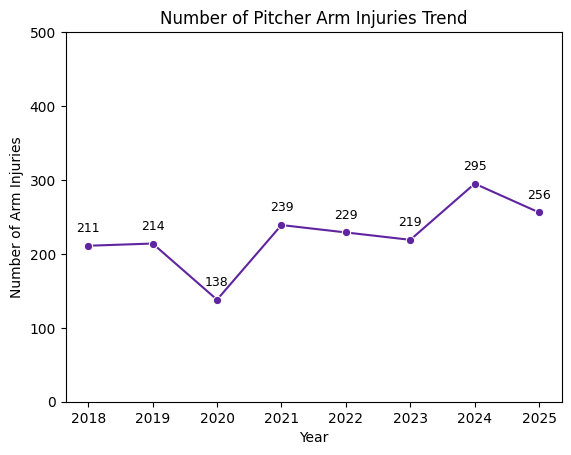

,player,year,had_arm_injury_this_year,prev_arm_inj_history
0,a.j. cole,2018,0,0
1,a.j. cole,2019,1,0
2,a.j. cole,2021,0,1
3,a.j. minter,2019,1,0
4,a.j. minter,2023,1,1
...,...,...,...,...
2925,zack wheeler,2019,1,0
2926,zack wheeler,2022,1,1
2927,zack wheeler,2025,0,2
2928,zebby matthews,2025,1,0


In [15]:
mlb_injuries = pd.read_csv('mlb_injuries.csv').copy()

pitcher_injuries = mlb_injuries[mlb_injuries['pos'].isin(['SP', 'P', 'RP'])].sort_values(by='start_date', ascending=False).reset_index(drop=True).copy()

## fixing the missing data values for start_date and end_date
pitcher_injuries['start_date'] = pitcher_injuries.apply(lambda x: (
    '20' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[2] 
    + '-' 
    + ('0' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip() 
       if int(x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip()) < 10 
       else x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip()
    ) 
    + '-' 
    + ('0' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip() 
       if int(x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip()) < 10 
       else x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip()
    ))
    if pd.isna(x['start_date']) else x['start_date'], axis=1)

pitcher_injuries['start_date'] = pd.to_datetime(pitcher_injuries['start_date']) - pd.Timedelta(days=1)
pitcher_injuries['end_date'] = pitcher_injuries['end_date'].fillna('TBD') ## fill in 

## deals with end dates being TBD --> TBDs b/c players missed the entire rest of the season (we'll assume it to be the same case across the board)
## these dates represent the last day of the regular season for those respective seasons
season_ends = {2018: '2018-10-01', 
               2019: '2019-09-29', 
               2020: '2020-09-27', 
               2021: '2021-10-03', 
               2022: '2022-10-05', 
               2023: '2023-10-01', 
               2024: '2024-09-24', 
               2025: '2025-09-30'
               }

season_starts = {2018: '2018-03-29', 
                 2019: '2019-03-20', 
                 2020: '2020-07-23', 
                 2021: '2021-04-01', 
                 2022: '2022-04-07', 
                 2023: '2023-03-30', 
                 2024: '2024-03-20', 
                 2025: '2025-03-18'
                 }

end_date_mask = pitcher_injuries['end_date'] == 'TBD'
pitcher_injuries.loc[end_date_mask, 'end_date'] = (pitcher_injuries.loc[end_date_mask, 'year'].map(season_ends).fillna('TBD'))
pitcher_injuries['end_date'] = pd.to_datetime(pitcher_injuries['end_date'], errors='coerce')

## fills in the missing IL type and injury from the raw data
pitcher_injuries['il_type'] = pitcher_injuries.apply(lambda x: x['reason_raw'].split(' -')[0].strip() if pd.isna(x['il_type']) else x['il_type'], axis=1)
pitcher_injuries['injury'] = pitcher_injuries.apply(lambda x: x['reason_raw'].split(' -')[1].split(':')[0].strip() if pd.isna(x['injury']) else x['injury'], axis=1)

pitcher_injuries['player'] = pitcher_injuries['player'].str.lower() ## normalizes player name
pitcher_injuries['year'] = pitcher_injuries['year'].astype(int)
pitcher_injuries['il_days'] = (pitcher_injuries['end_date'] - pitcher_injuries['start_date']).dt.days ## how many days on the IL
pitcher_injuries['season_start'] = pd.to_datetime(pitcher_injuries['year'].map(season_starts), errors='coerce') ## last day of that season
pitcher_injuries['season_end'] = pd.to_datetime(pitcher_injuries['year'].map(season_ends), errors='coerce') ## last day of that season
pitcher_injuries['il_before_season_end'] = (pitcher_injuries['season_end'] - pitcher_injuries['start_date']).dt.days ## days between being placed on the IL and season end

# pitcher_injuries = pitcher_injuries[['year', 'player', 'pos', 'team', 'il_type', 'injury', 'il_days', 'il_before_season_end', 'start_date', 'end_date']].copy()

pitcher_arm_injuries = ['Shoulder', 'Elbow', 'Elbow Tommy John', 'Ulnar Nerve', 'Arm'] ## what we're considering "Arm" injuries
## normalizing those arm injuries since that's what we care about
pitcher_injuries['injury'] = pitcher_injuries['injury'].apply(lambda x: 'Arm' if x in pitcher_arm_injuries else x)

cleaned_up_results = []
for i in pitcher_injuries['player'].unique():
    df_player = pitcher_injuries[pitcher_injuries['player'] == i]
    cleaned = overlapping_injury_checker(df_player)
    cleaned_up_results.append(cleaned)

pitcher_injuries_cleaned = pd.concat(cleaned_up_results, ignore_index=True).copy()
pitcher_injuries_cleaned = pitcher_injuries_cleaned.sort_values(by=['player', 'start_date'], ascending=[True, False]).reset_index(drop=True)

## injury trend of arm injuries over the years
injury_trend = pitcher_injuries_cleaned[pitcher_injuries_cleaned['injury'] == 'Arm'].reset_index(drop=True).copy()
injury_trend = injury_trend.groupby('year').size().reset_index(name='num_injury_occurences').copy()

plt.figure()
ax = sns.lineplot(data=injury_trend, x='year', y='num_injury_occurences', color=purple_color, marker='o')
for x, y in zip(injury_trend['year'], injury_trend['num_injury_occurences']):
    ax.annotate(text=str(y), xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=9)
plt.ylim(0, 500)
plt.xlabel('Year')
plt.ylabel('Number of Arm Injuries')
plt.title('Number of Pitcher Arm Injuries Trend')
plt.show()

## creating the injury history flag + target label --> arm injury this year
pitcher_injuries_cleaned["had_arm_injury_this_year"] = (pitcher_injuries_cleaned["injury"] == "Arm").astype(int)
yearly_injuries = (pitcher_injuries_cleaned.groupby(["player", "year"], as_index=False).agg({"had_arm_injury_this_year": "max"})).copy()
yearly_injuries = yearly_injuries.sort_values(["player", "year"]).copy()
yearly_injuries["prev_arm_inj_history"] = (yearly_injuries.groupby("player")["had_arm_injury_this_year"].transform(lambda s: s.cumsum().shift(fill_value=0)))
yearly_injuries

In [16]:
yearly_injuries

,player,year,had_arm_injury_this_year,prev_arm_inj_history
0,a.j. cole,2018,0,0
1,a.j. cole,2019,1,0
2,a.j. cole,2021,0,1
3,a.j. minter,2019,1,0
4,a.j. minter,2023,1,1
...,...,...,...,...
2925,zack wheeler,2019,1,0
2926,zack wheeler,2022,1,1
2927,zack wheeler,2025,0,2
2928,zebby matthews,2025,1,0


In [25]:
pitcher_data_w_injuries = temp.merge(yearly_injuries, how='left', left_on=['player_name', 'game_year'], right_on=['player', 'year']).copy()
pitcher_data_w_injuries = pitcher_data_w_injuries.drop(columns=['player', 'year']).copy()
pitcher_data_w_injuries['had_arm_injury_this_year'] = pitcher_data_w_injuries['had_arm_injury_this_year'].fillna(0)
pitcher_data_w_injuries['prev_arm_inj_history'] = pitcher_data_w_injuries['prev_arm_inj_history'].fillna(0)
pitcher_data_w_injuries.isna().sum()

cols_to_impute = [
    'BB_avg_spin',
    'OS_avg_spin',
    'OS_avg_spin_axis',
    'BB_max_spin',
    'OS_max_spin',
    'OS_max_spin_axis'
]

pitcher_data_w_injuries[cols_to_impute] = (pitcher_data_w_injuries[cols_to_impute].apply(lambda col: col.fillna(col.mean())))

pitcher_data_w_injuries

,player_name,pitcher,game_year,num_pitches_thrown,num_games,num_bf,bf_per_game,pitches_per_game,pitcher_role,hrel_sd,vrel_sd,BB%,FB%,OS%,BB_avg_velo,FB_avg_velo,OS_avg_velo,BB_avg_hb,FB_avg_hb,OS_avg_hb,BB_avg_ivb,FB_avg_ivb,OS_avg_ivb,BB_avg_spin,FB_avg_spin,OS_avg_spin,BB_avg_ext,FB_avg_ext,OS_avg_ext,BB_avg_spin_axis,FB_avg_spin_axis,OS_avg_spin_axis,BB_max_velo,FB_max_velo,OS_max_velo,BB_max_hb,FB_max_hb,OS_max_hb,BB_max_ivb,FB_max_ivb,OS_max_ivb,BB_max_spin,FB_max_spin,OS_max_spin,BB_max_ext,FB_max_ext,OS_max_ext,BB_max_spin_axis,FB_max_spin_axis,OS_max_spin_axis,id,birth_year,birth_country,height,weight,age,bmi,had_arm_injury_this_year,prev_arm_inj_history
0,jason adam,592094,2018,571,31,142,4.580645,18.419355,RP,0.170480,0.266944,0.309982,0.611208,0.078809,77.410734,94.093123,89.073333,14.580339,-7.237479,-14.816000,-8.945763,15.531576,4.024000,2516.039548,2579.658046,1871.590909,5.863842,6.486819,6.433333,58.474576,204.836676,254.577778,79.7,96.6,91.4,19.44,-1.08,-9.12,0.36,20.52,9.00,2765.0,2902,2133.0,6.6,7.0,6.9,91,219,280.0,592094,1991,USA,1.905004,103.854875,27,28.617731,0.0,0.0
1,austin adams,613534,2018,24,2,7,3.500000,12.000000,RP,0.113520,0.133752,0.416667,0.583333,0.000000,88.620000,94.785714,0.000000,6.396000,-3.737143,0.000000,-2.964000,11.640000,0.000000,2716.375000,2496.214286,0.000000,5.280000,5.714286,0.000000,63.200000,197.571429,0.000000,90.5,96.1,0.0,9.36,-0.84,0.00,0.24,16.68,0.00,2928.0,2613,0.0,5.5,6.0,0.0,92,225,0.0,613534,1991,USA,1.905004,99.773243,27,27.493016,0.0,0.0
2,chance adams,664856,2018,153,3,34,11.333333,51.000000,RP,0.151870,0.118730,0.326797,0.666667,0.006536,81.434000,92.885294,84.900000,13.166400,-3.587059,-13.800000,-1.984800,14.676471,12.960000,2737.291667,2325.549020,1814.000000,5.852000,6.242157,6.100000,84.800000,193.647059,227.000000,86.7,94.9,84.9,21.00,1.80,-13.80,6.48,18.60,12.96,2979.0,2518,1814.0,6.2,6.8,6.1,125,213,227.0,664856,1994,USA,1.854204,104.308390,24,30.339216,0.0,0.0
3,matt albers,458006,2018,672,34,158,4.647059,19.764706,RP,0.163354,0.122160,0.238095,0.648810,0.113095,85.108750,91.657110,83.102632,3.638250,-16.092110,-14.355789,4.254750,8.069450,2.684211,2334.839744,2045.396789,1430.434211,6.082500,6.425000,6.221053,135.868750,243.094037,259.684211,89.1,95.0,86.4,8.88,-7.08,-8.40,13.32,17.64,7.80,2594.0,2398,1838.0,6.5,7.6,6.9,212,275,285.0,458006,1983,USA,1.854204,102.040816,35,29.679668,1.0,0.0
4,sandy alcantara,645261,2018,567,6,148,24.666667,94.500000,SP,0.218418,0.142902,0.268078,0.604938,0.126984,84.908553,95.412828,89.011111,4.432105,-11.618659,-14.683333,0.907895,11.302391,4.380000,2359.910345,2270.113703,1782.549296,5.527632,6.007580,6.104167,102.407895,225.198251,253.305556,89.8,98.8,91.4,11.64,-2.40,-11.40,10.92,19.80,11.28,2624.0,2541,2056.0,6.1,6.7,6.7,201,269,268.0,645261,1995,Dominican Republic,1.955804,90.702948,23,23.712142,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,bruce zimmermann,669145,2025,91,1,28,28.000000,91.000000,SP,0.134028,0.112564,0.307692,0.483516,0.208791,81.121429,89.395455,82.747368,-4.165714,11.416364,10.825263,-5.695714,8.113636,2.381053,2355.464286,2366.272727,1541.631579,6.164286,6.122727,6.231579,319.642857,137.977273,124.105263,84.5,91.4,83.8,3.24,19.32,12.60,-1.44,15.72,6.36,2592.0,2616,1780.0,6.4,6.3,6.4,356,150,133.0,669145,1995,USA,1.905004,107.029478,30,29.492508,0.0,0.0
6296,tyler zuber,676604,2025,245,10,58,5.800000,24.500000,RP,0.168883,0.196223,0.514286,0.416327,0.069388,84.437302,94.344118,87.958824,13.985714,-10.340000,-14.781176,3.604762,13.194118,1.814118,2674.182540,2294.774510,1214.235294,6.004762,6.139216,6.264706,91.023810,219.294118,244.588235,90.5,96.7,90.1,22.92,4.20,-10.44,12.36,19.80,7.32,2870.0,2566,1384.0,6.5,6.5,6.5,170,231,256.0,676604,1995,USA,1.803404,88.435374,30,27.191937,0.0,1.0
6297

In [26]:
pitcher_data_w_injuries.to_csv('mlb_injuries.csv')

## EDA

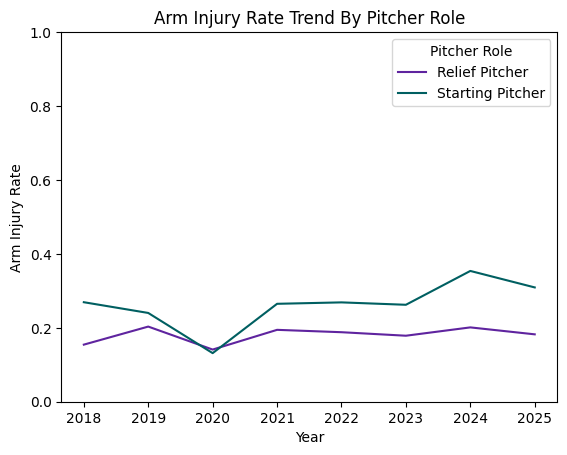

In [43]:
injuries = pitcher_data_w_injuries.groupby(['game_year', 'pitcher_role'])['had_arm_injury_this_year'].sum().reset_index().copy()
denom = pitcher_data_w_injuries.groupby(['game_year', 'pitcher_role'])['pitcher'].nunique().reset_index(name='num_pitchers')
rates = injuries.merge(denom, on=['game_year', 'pitcher_role'])
rates['injury_rate'] = rates['had_arm_injury_this_year'] / rates['num_pitchers']

palette = {"SP": teal_color, "RP": purple_color}
plt.figure()
ax = sns.lineplot(data=rates, x='game_year', y='injury_rate', hue='pitcher_role', palette=palette)
plt.ylim(0, 1)
plt.xlabel('Year')
plt.ylabel('Arm Injury Rate')
plt.title('Arm Injury Rate Trend By Pitcher Role')
handles, labels = ax.get_legend_handles_labels()
label_map = {"SP": "Starting Pitcher", "RP": "Relief Pitcher"}
labels = [label_map.get(l, l) for l in labels]
ax.legend(handles, labels, title="Pitcher Role")
plt.show()

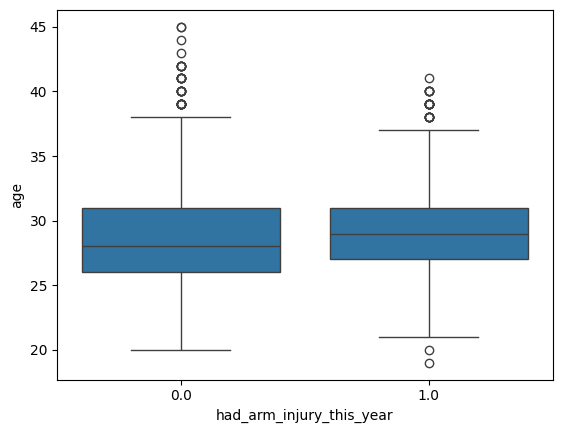

In [46]:
plt.figure()
sns.boxplot(data = pitcher_data_w_injuries, x='had_arm_injury_this_year', y='age')
plt.show()

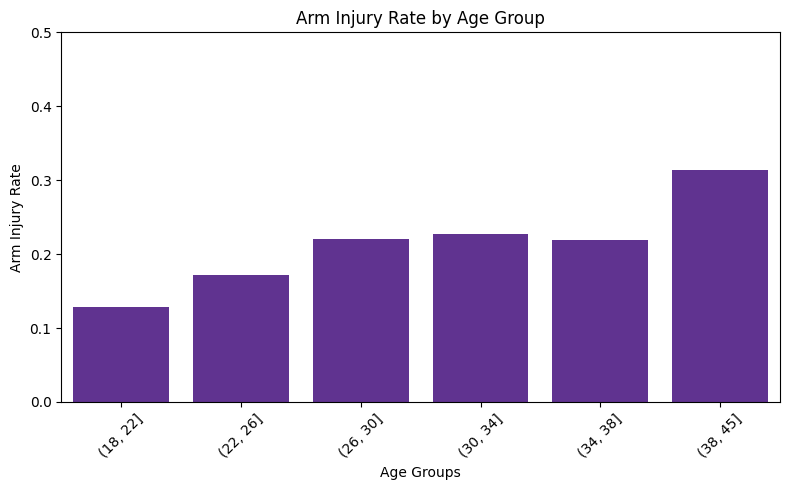

In [53]:
pitcher_data_w_injuries['age_bin'] = pd.cut(pitcher_data_w_injuries['age'], bins=[18, 22, 26, 30, 34, 38, 45])
injury_by_age = (pitcher_data_w_injuries.groupby('age_bin', observed=True)['had_arm_injury_this_year'].mean())
injury_by_age

plt.figure(figsize=(8, 5))
sns.barplot(injury_by_age, color=purple_color)
plt.ylabel('Arm Injury Rate')
plt.xlabel('Age Groups')
plt.title('Arm Injury Rate by Age Group')
plt.xticks(rotation=45)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()